## Synthetic construct 2 (cc2 run GridIon from EpiNano paper) CNN WaveNet prediction analysis

    15/03/2022

Data have been produced by *CtoUclassifier_pipe_currents_extraction_step* pipeline.

In [1]:
# import basic modules
import os, sys

# add parent folder of the C_to_U_classifier_plus_min package to path in order to be loaded into the current session
sys.path.append("/lustrehome/afonzino")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn
from C_to_U_classifier_plus_min import utils
import pysam
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
# define input paths for CNN WaveNet prediction on basecalling features
dfCTaggr_filepath = "/lustre/bio_running/C_to_U_editing_minimap2_spliced/cc2.model_CNN_cc2_PlusMin/df_CT_predicted_aggregated_08.tsv"
ref_filepath = "/lustre/bio_running/curlcakes_runs/refs/cc.fasta"

/lustrehome/afonzino/C_to_U_classifier_plus_min/utils.py:71: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Tfreq_native"] = df["Tfreq_native"] + offset
/lustrehome/afonzino/C_to_U_classifier_plus_min/utils.py:72: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["Tfreq_corrected"] = df["Tfreq_corrected"] + offset


[2022-03-25 18:14:53.180199] Retrieving Contigs and lengths...
[2022-03-25 18:14:53.180711] Merging dataframes for region chr1...
[2022-03-25 18:14:53.192294] Merging finished....start plotting...


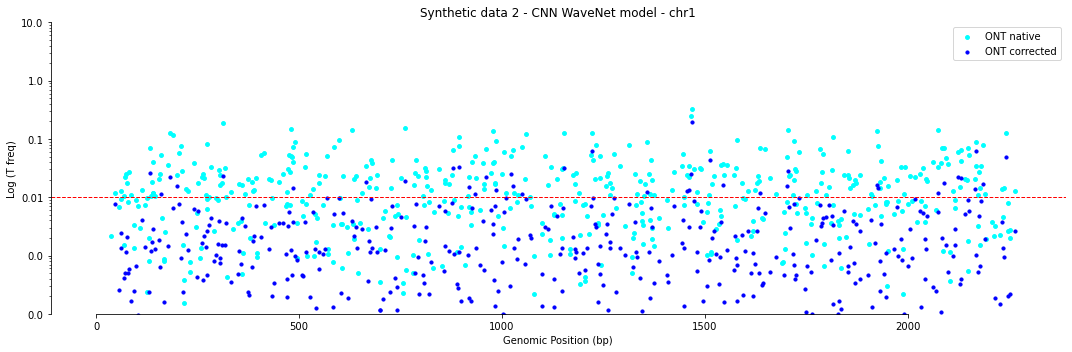

[2022-03-25 18:14:53.778461] Merging dataframes for region chr2...
[2022-03-25 18:14:53.783164] Merging finished....start plotting...


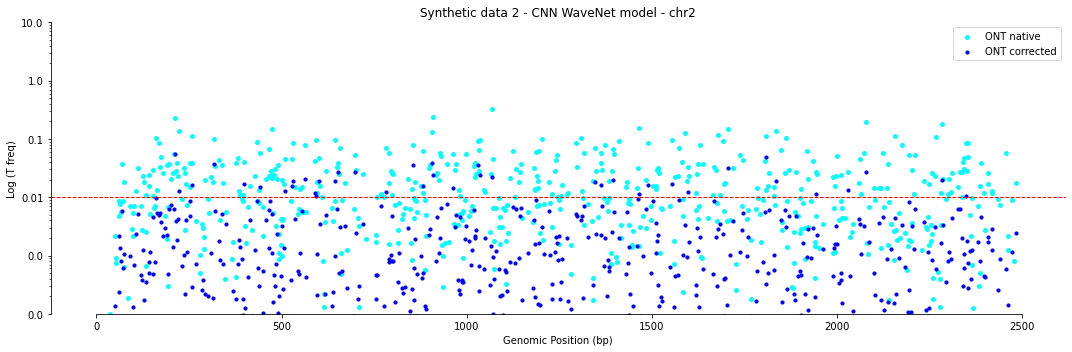

[2022-03-25 18:14:54.302691] Merging dataframes for region chr3...
[2022-03-25 18:14:54.307451] Merging finished....start plotting...


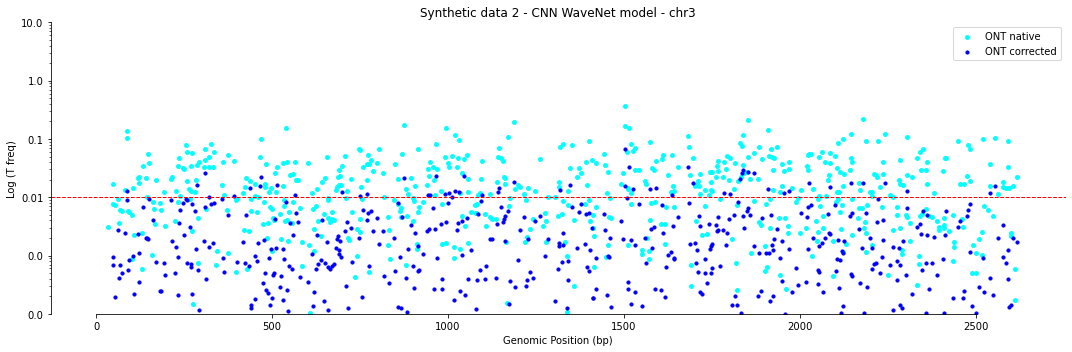

[2022-03-25 18:14:54.753697] Merging dataframes for region chr4...
[2022-03-25 18:14:54.758544] Merging finished....start plotting...


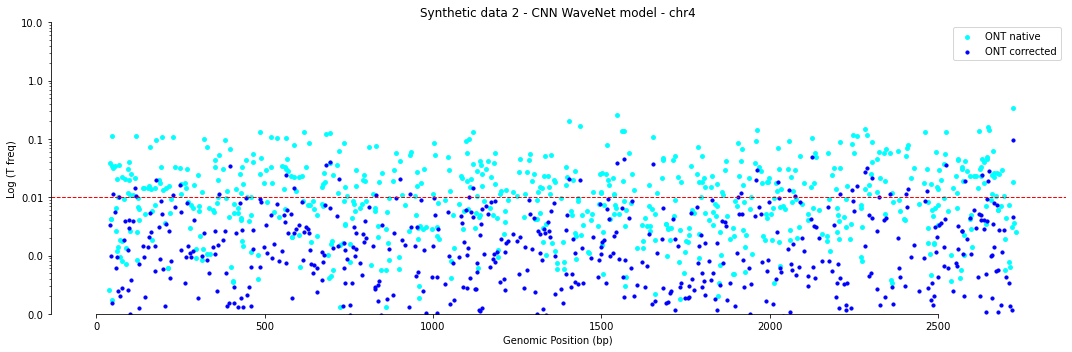

In [3]:
utils.plot_frequencies(reference_filepath=ref_filepath, 
                       df_aggregated_filepath=dfCTaggr_filepath, 
                       title="Synthetic data 2 - CNN WaveNet model",
                       save_folderpath="/lustre/bio_running/C_to_U_editing_minimap2_spliced/src_jupyter_notebooks_multi_thr/cc2/cc2.CNN_wavenet_08",
                       log=True,
                       offset=0,
                       native_color="cyan",
                       corrected_color="blue",
                       native_size=15,
                       corrected_size=10,
                       freq_threshold=0.01,
                       strand="+")

In [4]:
dfCTaggr = pd.read_table(dfCTaggr_filepath)
# drop unwanted (-) strand sites
dfCTaggr = dfCTaggr.query("strand == '+'")
dfCTaggr

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected
0,chr1,37,+,3,0,1377,0.002179,0.000000
1,chr1,47,+,137,90,11601,0.011809,0.007758
2,chr1,55,+,80,3,11742,0.006813,0.000255
3,chr1,61,+,105,15,11306,0.009287,0.001327
4,chr1,62,+,150,29,11792,0.012720,0.002459
...,...,...,...,...,...,...,...,...
2724,chr4,2719,+,427,16,138447,0.003084,0.000116
2725,chr4,2722,+,46505,13273,137772,0.337550,0.096340
2726,chr4,2723,+,2553,629,138874,0.018384,0.004529
2728,chr4,2727,+,506,6,139638,0.003624,0.000043


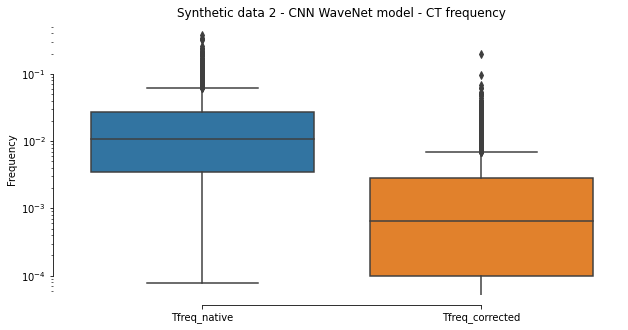

In [5]:
plt.figure(figsize=(10,5))
sn.boxplot(data=dfCTaggr[["Tfreq_native", "Tfreq_corrected"]])
plt.yscale("log")
plt.title("Synthetic data 2 - CNN WaveNet model - CT frequency")
plt.ylabel("Frequency")
sn.despine(offset=10, trim=True)
plt.savefig("/lustre/bio_running/C_to_U_editing_minimap2_spliced/src_jupyter_notebooks_multi_thr/cc2/cc2.CNN_wavenet_08/cc2.CNN WaveNet.aggregated.boxplot.tiff")
plt.show()

In [6]:
dfCTaggr.Tfreq_native.describe()

count    2494.000000
mean        0.022362
std         0.032964
min         0.000079
25%         0.003495
50%         0.010627
75%         0.026861
max         0.373323
Name: Tfreq_native, dtype: float64

In [7]:
dfCTaggr.Tfreq_corrected.describe()

count    2494.000000
mean        0.002950
std         0.007360
min         0.000000
25%         0.000097
50%         0.000642
75%         0.002808
max         0.195073
Name: Tfreq_corrected, dtype: float64

### Let's produce a classification report and a confusion matrix

In [8]:
# retrieve position on curlcake reference with C base
# focus only on (+) strand since it is the only one important in this experimental set-up
ref = pysam.FastaFile(ref_filepath)

putative_ed_pos = []
for contig in ref.references:
    chrom = ref.fetch(contig)
    counter = 0
    for pos in chrom:
        counter += 1
        if pos == "C":
            putative_ed_pos.append([contig, counter, "+"])
C_pos_curlcake = pd.DataFrame(putative_ed_pos, columns=["region", "position", "strand"])

C_pos_curlcake

,region,position,strand
0,chr1,3,+
1,chr1,14,+
2,chr1,17,+
3,chr1,19,+
4,chr1,21,+
...,...,...,...
2516,chr4,2719,+
2517,chr4,2722,+
2518,chr4,2723,+
2519,chr4,2727,+


In [9]:
# merge resulting C position reference dataframe with genome space
cc2_genome_space = C_pos_curlcake.merge(dfCTaggr, how="left", left_on=["region", "position", "strand"], right_on=["region", "position", "strand"]).fillna(0).copy()
cc2_genome_space

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected
0,chr1,3,+,0.0,0.0,0.0,0.000000,0.000000
1,chr1,14,+,0.0,0.0,0.0,0.000000,0.000000
2,chr1,17,+,0.0,0.0,0.0,0.000000,0.000000
3,chr1,19,+,0.0,0.0,0.0,0.000000,0.000000
4,chr1,21,+,0.0,0.0,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...
2516,chr4,2719,+,427.0,16.0,138447.0,0.003084,0.000116
2517,chr4,2722,+,46505.0,13273.0,137772.0,0.337550,0.096340
2518,chr4,2723,+,2553.0,629.0,138874.0,0.018384,0.004529
2519,chr4,2727,+,506.0,6.0,139638.0,0.003624,0.000043


In [10]:
# retrieve reference 5mer for each site and then predict editing (cc1 thresholds)
cc2_genome_space = utils.predict_editing_custom_thrs(cc2_genome_space, 
                                                     custom_thrs_filepath="/lustre/bio_running/C_to_U_editing_minimap2_spliced/src_jupyter_notebooks_multi_thr/cc1/cc1.CNN_wavenet_08/cc1.CNN.freq_thresholds.tsv",
                                                     ref_filepath="/lustre/bio_running/curlcakes_runs/refs/cc.fasta",
                                                     min_thr=0.01) # min thr 95% percentile of cc1 error
cc2_genome_space

100%|██████████| 2521/2521 [00:00<00:00, 14221.15it/s]


,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat
0,chr1,3,+,0.0,0.0,0.0,0.000000,0.000000,ATCAT,0
1,chr1,14,+,0.0,0.0,0.0,0.000000,0.000000,TACGA,0
2,chr1,17,+,0.0,0.0,0.0,0.000000,0.000000,GACTC,0
3,chr1,19,+,0.0,0.0,0.0,0.000000,0.000000,CTCAC,0
4,chr1,21,+,0.0,0.0,0.0,0.000000,0.000000,CACTA,0
...,...,...,...,...,...,...,...,...,...,...
2516,chr4,2719,+,427.0,16.0,138447.0,0.003084,0.000116,GACAA,0
2517,chr4,2722,+,46505.0,13273.0,137772.0,0.337550,0.096340,AACCG,0
2518,chr4,2723,+,2553.0,629.0,138874.0,0.018384,0.004529,ACCGA,0
2519,chr4,2727,+,506.0,6.0,139638.0,0.003624,0.000043,AACAA,0


In [11]:
# drop position with a depth lower than threshold
cc2_genome_space = cc2_genome_space.query("depth_stranded > 49").copy()

In [12]:
cc2_genome_space.query("Tfreq_native > 0.01")

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_hat
8,chr1,47,+,137.0,90.0,11601.0,0.011809,0.007758,GTCGA,0
11,chr1,62,+,150.0,29.0,11792.0,0.012720,0.002459,ACCTT,0
12,chr1,68,+,104.0,4.0,9906.0,0.010499,0.000404,GACCC,0
14,chr1,70,+,268.0,6.0,11933.0,0.022459,0.000503,CCCTA,0
15,chr1,74,+,197.0,9.0,7955.0,0.024764,0.001131,ATCTC,0
...,...,...,...,...,...,...,...,...,...,...
2506,chr4,2682,+,3570.0,392.0,141438.0,0.025241,0.002772,TGCGG,0
2508,chr4,2690,+,4048.0,158.0,139513.0,0.029015,0.001133,CACTG,0
2509,chr4,2695,+,1447.0,380.0,139738.0,0.010355,0.002719,GTCAG,0
2517,chr4,2722,+,46505.0,13273.0,137772.0,0.337550,0.096340,AACCG,0


In [13]:
freq_threshold = 0.01

# create y vectors of expected, revealed without and with CNN WaveNet correction above a minumum frequency threshold 
cc2_genome_space["y_expected"] = [0 for i in range(cc2_genome_space.shape[0])]
cc2_genome_space["y_noCorrection"] = [1 if (i>freq_threshold) else 0 for i in cc2_genome_space.loc[:,"Tfreq_native"]]
cc2_genome_space["y_CNNwavenetCorrection"] = cc2_genome_space["y_hat"]
# drop y
cc2_genome_space.drop("y_hat", axis=1, inplace=True)
cc2_genome_space

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected,5mer,y_expected,y_noCorrection,y_CNNwavenetCorrection
7,chr1,37,+,3.0,0.0,1377.0,0.002179,0.000000,GGCTG,0,0,0
8,chr1,47,+,137.0,90.0,11601.0,0.011809,0.007758,GTCGA,0,1,0
9,chr1,55,+,80.0,3.0,11742.0,0.006813,0.000255,ATCAA,0,0,0
10,chr1,61,+,105.0,15.0,11306.0,0.009287,0.001327,AACCT,0,0,0
11,chr1,62,+,150.0,29.0,11792.0,0.012720,0.002459,ACCTT,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...
2516,chr4,2719,+,427.0,16.0,138447.0,0.003084,0.000116,GACAA,0,0,0
2517,chr4,2722,+,46505.0,13273.0,137772.0,0.337550,0.096340,AACCG,0,1,0
2518,chr4,2723,+,2553.0,629.0,138874.0,0.018384,0.004529,ACCGA,0,1,0
2519,chr4,2727,+,506.0,6.0,139638.0,0.003624,0.000043,AACAA,0,0,0


In [14]:
print("0 no edited, 1 edited")
print("Expected classes:\n", cc2_genome_space["y_expected"].value_counts())
print("\nDetected classes without correction:\n", cc2_genome_space["y_noCorrection"].value_counts())
print("\nDetected classes with CNN wavenet correction:\n", cc2_genome_space["y_CNNwavenetCorrection"].value_counts())

0 no edited, 1 edited
Expected classes:
 0    2494
Name: y_expected, dtype: int64

Detected classes without correction:
 1    1279
0    1215
Name: y_noCorrection, dtype: int64

Detected classes with CNN wavenet correction:
 0    2412
1      82
Name: y_CNNwavenetCorrection, dtype: int64


In [15]:
# produce classification report
# calculate metrics on aggregated data
print("1 editing, 0 no-editing\n")

print("\nClassification Report without (native nanopore) correction:\n", classification_report(cc2_genome_space["y_expected"], cc2_genome_space["y_noCorrection"]))
print("\nClassification Report with CNN wavenet correction:\n", classification_report(cc2_genome_space["y_expected"], cc2_genome_space["y_CNNwavenetCorrection"]))

1 editing, 0 no-editing


Classification Report without (native nanopore) correction:
               precision    recall  f1-score   support

           0       1.00      0.49      0.66      2494
           1       0.00      0.00      0.00         0

    accuracy                           0.49      2494
   macro avg       0.50      0.24      0.33      2494
weighted avg       1.00      0.49      0.66      2494


Classification Report with CNN wavenet correction:
               precision    recall  f1-score   support

           0       1.00      0.97      0.98      2494
           1       0.00      0.00      0.00         0

    accuracy                           0.97      2494
   macro avg       0.50      0.48      0.49      2494
weighted avg       1.00      0.97      0.98      2494



/lustrehome/afonzino/.conda/envs/nanocompore/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


/lustrehome/afonzino/C_to_U_classifier_plus_min/utils.py:197: RuntimeWarning: invalid value encountered in long_scalars
  recall    = cf[1,1] / sum(cf[1,:])


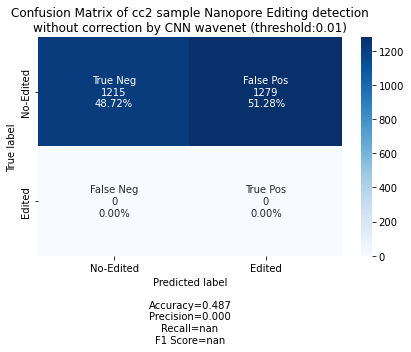

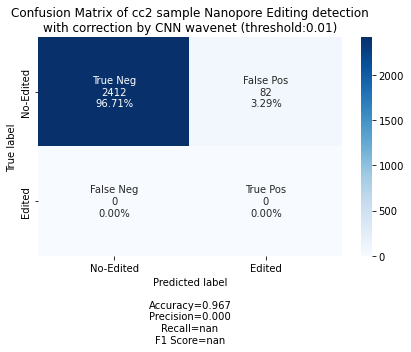

In [16]:
# confusion matrices plots

labels = ["True Neg", "False Pos", "False Neg", "True Pos"]
categories = ["No-Edited", "Edited"]

utils.make_confusion_matrix(confusion_matrix(cc2_genome_space["y_expected"], cc2_genome_space["y_noCorrection"]), 
                      group_names=labels,
                      categories=categories,
                      title = f"Confusion Matrix of cc2 sample Nanopore Editing detection\nwithout correction by CNN wavenet (threshold:{freq_threshold})",
                      figsize=(6,5),
                      path="/lustre/bio_running/C_to_U_editing_minimap2_spliced/src_jupyter_notebooks_multi_thr/cc2/cc2.CNN_wavenet_08/ConfMatrix_CNNwavenet_noCorrection.tiff")

utils.make_confusion_matrix(confusion_matrix(cc2_genome_space["y_expected"], cc2_genome_space["y_CNNwavenetCorrection"]), 
                      group_names=labels,
                      categories=categories,
                      title = f"Confusion Matrix of cc2 sample Nanopore Editing detection\nwith correction by CNN wavenet (threshold:{freq_threshold})",
                      figsize=(6,5),
                      path="/lustre/bio_running/C_to_U_editing_minimap2_spliced/src_jupyter_notebooks_multi_thr/cc2/cc2.CNN_wavenet_08/ConfMatrix_CNNwavenet_Correction.tiff")

## 5mer level analys of residual errors

In [17]:
ref = pysam.FastaFile(ref_filepath)
total_Cs = 0 
for r in ref.references:
    Cs = ref.fetch(r).count("C")
    total_Cs += Cs
    print(r, Cs)
print("Total Cs:", total_Cs)
ref.close()

chr1 549
chr2 608
chr3 645
chr4 719
Total Cs: 2521


In [18]:
dfCTaggr

,region,position,strand,T_native,T_corrected,depth_stranded,Tfreq_native,Tfreq_corrected
0,chr1,37,+,3,0,1377,0.002179,0.000000
1,chr1,47,+,137,90,11601,0.011809,0.007758
2,chr1,55,+,80,3,11742,0.006813,0.000255
3,chr1,61,+,105,15,11306,0.009287,0.001327
4,chr1,62,+,150,29,11792,0.012720,0.002459
...,...,...,...,...,...,...,...,...
2724,chr4,2719,+,427,16,138447,0.003084,0.000116
2725,chr4,2722,+,46505,13273,137772,0.337550,0.096340
2726,chr4,2723,+,2553,629,138874,0.018384,0.004529
2728,chr4,2727,+,506,6,139638,0.003624,0.000043


In [19]:
with tqdm(total=dfCTaggr.shape[0]) as pbar:
    refs = []
    ref = pysam.FastaFile(ref_filepath)
    for s in dfCTaggr.itertuples():
        site = f"{s.region}:{s.position}{s.strand}"
        pos1based=s.position
        pos0based=pos1based-1
        start=pos0based-2
        stop=pos0based+3
        strand = s.strand
        reference = ref.fetch(s.region, start, stop)
        if strand == "+":
            refs.append(reference)
        elif strand == "-":
            refs.append(utils.get_rev_compl(reference))
        else:
            # stange strand. append unkwnown value as "."
            refs.append(".")
        pbar.update(1)
    ref.close()
dfCTaggr["5mer"] = refs

100%|██████████| 2494/2494 [00:00<00:00, 232716.22it/s]


In [20]:
dfCTaggr[dfCTaggr.Tfreq_corrected > 0.01].groupby("5mer").Tfreq_corrected.describe().sort_values("max")

,count,mean,std,min,25%,50%,75%,max
5mer,,,,,,,,
CGCAT,1.0,0.010122,NaN,0.010122,0.010122,0.010122,0.010122,0.010122
GTCGG,1.0,0.010238,NaN,0.010238,0.010238,0.010238,0.010238,0.010238
AACCC,1.0,0.010401,NaN,0.010401,0.010401,0.010401,0.010401,0.010401
TGCTC,1.0,0.010423,NaN,0.010423,0.010423,0.010423,0.010423,0.010423
CACCC,1.0,0.010674,NaN,0.010674,0.010674,0.010674,0.010674,0.010674
...,...,...,...,...,...,...,...,...
CGCGG,7.0,0.028837,0.018521,0.012049,0.013716,0.024119,0.038400,0.061459
CTCGG,4.0,0.029369,0.022935,0.013014,0.015140,0.020847,0.035076,0.062766
ATCTC,2.0,0.040321,0.039501,0.012390,0.026356,0.040321,0.054287,0.068253


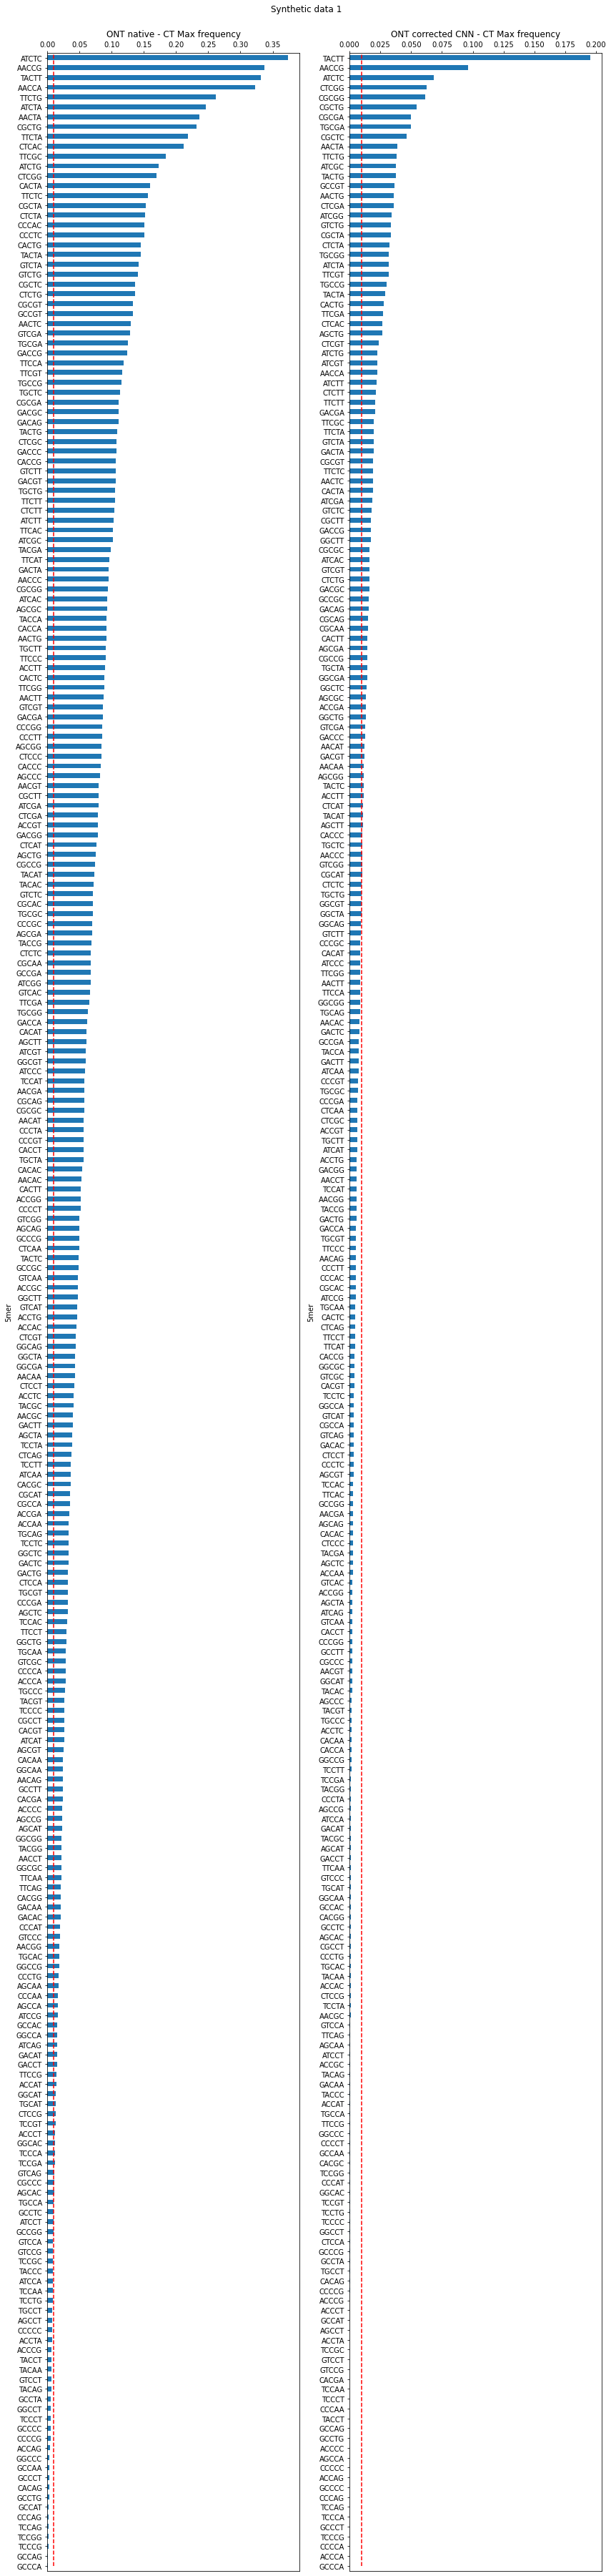

In [21]:
f, axes = plt.subplots(1,2, figsize=(12,50))

dfCTaggr.groupby("5mer").Tfreq_native.describe().sort_values("max")["max"].plot.barh(ax=axes[0])
axes[0].vlines(0.01, 0, 256, "r", "--")
axes[0].set_title("ONT native - CT Max frequency")
axes[0].xaxis.tick_top()

dfCTaggr.groupby("5mer").Tfreq_corrected.describe().sort_values("max")["max"].plot.barh(ax=axes[1])
axes[1].vlines(0.01, 0, 256, "r", "--")
axes[1].set_title("ONT corrected CNN - CT Max frequency")
axes[1].xaxis.tick_top()

plt.suptitle("Synthetic data 1", y= 1.00)
plt.tight_layout()
plt.savefig("Max CT freq error before and after CNN correction.tiff", dpi=100)
plt.show()

In [22]:
# save to disk table with all the max frequency to be used as custom threshold for each 5mer
dfCTaggr.groupby("5mer").Tfreq_corrected.describe().sort_values("max")["max"].to_csv("cc2.CNN.freq_thresholds.tsv", sep="\t")